In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz96_fdm
from assimilation import EnKF
from nmc import nmc

In [2]:
def da_rmse(nature, analysis, obs_intv):
    return np.sqrt(np.mean((analysis[:,::obs_intv] - nature[:,::obs_intv]) ** 2, axis=0))

In [3]:
x0 = np.random.randint(low=0, high=9, size=40)
x0 = x0[:,np.newaxis]  # (40, 1)
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)
nature = lorenz96_fdm(x0, ts)
nature.shape

(40, 1000)

In [4]:
Pb = nmc(lorenz96_fdm, nature, dt, 1, 0.1)
Pb

array([[ 4.83524246,  0.5856439 , -1.44761012, ..., -0.30952289,
        -1.05757573, -1.10352236],
       [ 0.5856439 ,  1.97810683,  0.75469343, ..., -0.49333275,
        -0.43672474, -1.04842352],
       [-1.44761012,  0.75469343,  3.3808667 , ..., -1.65586364,
        -0.94944564, -1.1227527 ],
       ...,
       [-0.30952289, -0.49333275, -1.65586364, ...,  3.12657588,
         1.45030866, -0.29154884],
       [-1.05757573, -0.43672474, -0.94944564, ...,  1.45030866,
         1.23839131, -0.03489132],
       [-1.10352236, -1.04842352, -1.1227527 , ..., -0.29154884,
        -0.03489132,  3.73621836]])

In [5]:
obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]
obs.shape

(40, 125)

In [6]:
R = np.eye(40) * 2
R

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [7]:
X_ini = x0 + np.random.randint(-15, 15, size=x0.shape)
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

In [8]:
enkf = EnKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle()

1.6886291562187719


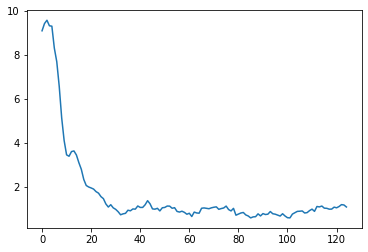

In [9]:
ensmean = enkf.analysis.mean(axis=0)

rmse = da_rmse(nature, ensmean, obs_intv)
plt.plot(rmse)
print(rmse.mean())

In [10]:
class DAbase:
    def __init__(self, model, dt, store_history=False):
        self._isstore = store_history
        self._params = {'alpha': 0, 'inflat': 1}
        self.model = model
        self.dt = dt
        self.X_ini = None
        
    def set_params(self, param_list, **kwargs):
        for key, value in kwargs.items():
            if key in param_list:
                self._params[key] = kwargs.get(key)
            else:
                raise ValueError(f'Invalid parameter: {key}')
        
    def _check_params(self, param_list):
        missing_params = []
        for var in param_list:
            if self._params.get(var) is None:
                missing_params.append(var)
        return missing_params
    
    
class EnKF(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ens_ini', 
            'obs', 
            'obs_interv', 
            'R', 
            'H_func', 
            'alpha', 
            'inflat'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        """xb.shape = (n_dim, n_ens)"""
        if H_func is None:
            H_func = lambda arr: arr
        
        N_ens = xb.shape[1]
        yo_ens = np.random.multivariate_normal(yo.ravel(), R, size=N_ens).T  # (ndim_yo, N_ens)
        xb_mean = xb.mean(axis=1)[:,np.newaxis]  # (ndim_xb, 1)
        
        xa_ens = np.zeros((xb.shape[0], N_ens))
        for iens in range(N_ens):
            xb_mean = xb.mean(axis=1)[:,np.newaxis]
            Xb_perturb = xb - xb_mean
            HXb_perturb = H_func(Xb_perturb) - H_func(Xb_perturb).mean(axis=1)[:,np.newaxis]
            
            PfH_T = Xb_perturb @ HXb_perturb.T / (N_ens-1)
            HPfH_T = HXb_perturb @ HXb_perturb.T / (N_ens-1)
            K = loc_mo * PfH_T @ np.linalg.inv(loc_oo * HPfH_T + R)
            xa_ens[:,[iens]] = xb[:,[iens]] + K @ (yo_ens[:,[iens]] - H_func(xb[:,[iens]]))
            
        return xa_ens
    
    def cycle(self, loc_mo, loc_oo):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ens_ini'].copy()
        obs = self._params['obs']
        R = self._params['R']
        H_func = self._params['H_func']
        alpha = self._params['alpha']
        inflat = self._params['inflat']
        
        ndim, N_ens = xb.shape
        background = np.zeros((N_ens, ndim, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.linspace(t_start, (cycle_len-1)*dt, cycle_len)
        
        for nc in range(cycle_num):
            # analysis
            xa = self._analysis(xb, obs[:,[nc]], R, H_func, loc_mo, loc_oo)
            
            # inflat
            xa_perturb = xa - xa.mean(axis=1)[:,np.newaxis]
            xa_perturb *= inflat
            xa = xa.mean(axis=1)[:,np.newaxis] + xa_perturb
            
            # ensemble forecast
            for iens in range(N_ens):
                x_forecast = model(xa[:,iens], ts)   # (ndim, ts.size)
                
                idx1 = nc*cycle_len
                idx2 = (nc+1)*cycle_len
                analysis[iens,:,idx1:idx2] = x_forecast
                background[iens,:,[idx1]] = xb[:,iens]
                background[iens,:,(idx1+1):idx2] = x_forecast[:,1:]
                
                # xb for next cycle
                xb[:,iens] = x_forecast[:,-1]
                
            # for next cycle
            t_start = int(ts[-1] + dt)
            ts = np.linspace(t_start, t_start+(cycle_len-1)*dt, cycle_len)
            
        self.background = background
        self.analysis = analysis

### localization with full observation

In [11]:
def dis_oo(i, j, L=2):
    if j < i:
        i, j = j, i
    dis_idx = j - i
    if dis_idx > 20:
        dis_idx = 40 - dis_idx
    return np.exp(-dis_idx**2 / (2*L**2))

dis_oo(2, 8)

0.011108996538242306

In [12]:
def dis_mo(i, j, L=2):
    return dis_oo(i, j, L)

In [13]:
# localization for model to observation
loc1 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc1[i,j] = dis_mo(i, j)
        
# localization for observation to observation
loc2 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc2[i,j] = dis_oo(i, j)

In [14]:
enkf = EnKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle(loc1, loc2)

0.9120259651576281


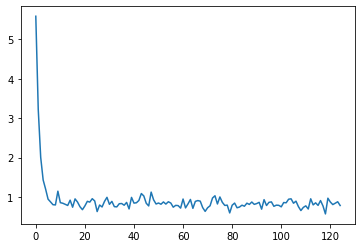

In [15]:
ensmean = enkf.analysis.mean(axis=0)

rmse = da_rmse(nature, ensmean, obs_intv)
plt.plot(rmse)
print(rmse.mean())

### localization with partial observation

In [29]:
## no localization

In [19]:
pobs = obs[::2,:]
pobs.shape

(20, 125)

In [26]:
loc1 = np.ones((40, 20))
loc2 = np.ones((20, 20))

In [27]:
enkf = EnKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': pobs,
    'obs_interv': obs_intv,
    'R': 2 * np.eye(20),
    'H_func': lambda arr: arr[::2,:],
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle(loc1, loc2)

3.1538748908552456


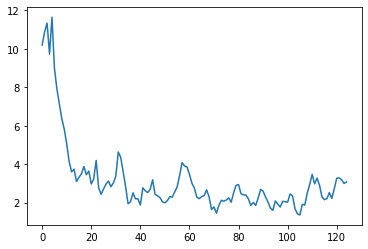

In [28]:
ensmean = enkf.analysis.mean(axis=0)

rmse = da_rmse(nature, ensmean, obs_intv)
plt.plot(rmse)
print(rmse.mean())

In [30]:
## with localization

In [54]:
def dis_mo(i, j, L=2):
    """i: model space, j: obs space"""
    j = j * 2 - 1    # convert j into model space
    dis_idx = min(abs(i-j), 40-abs(i-j))
    return np.exp(-dis_idx**2 / (2*L**2))
    
def dis_oo(i, j, L=2): 
    dis_idx = min(abs(i-j), 20-abs(i-j))
    dis_idx = dis_idx * 2
    return np.exp(-dis_idx**2 / (2*L**2))


loc1 = np.zeros((40, 20))
for i in range(40):
    for j in range(20):
        loc1[i,j] = dis_mo(i, j)

loc2 = np.zeros((20, 20))        
for i in range(20):
    for j in range(20):
        loc2[i,j] = dis_oo(i, j)

In [62]:
enkf = EnKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': pobs,
    'obs_interv': obs_intv,
    'R': 2 * np.eye(20),
    'H_func': lambda arr: arr[::2,:],
    'alpha': 0.3,
    'inflat': 1.2
}
enkf.set_params(**params)
enkf.cycle(loc1, loc2)

2.2722813926894156


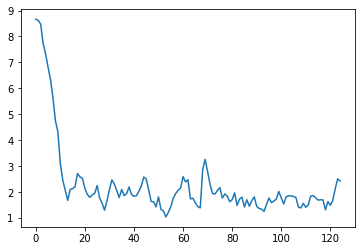

In [63]:
ensmean = enkf.analysis.mean(axis=0)

rmse = da_rmse(nature, ensmean, obs_intv)
plt.plot(rmse)
print(rmse.mean())